In [1]:
#Code Box 3
class Material:
 
  def __init__(self, name, input_rgb_vals, output_val, confidence_threshold=0):
    self.name = name
    self.input_rgb_vals = input_rgb_vals
    self.output_val = output_val
    self.confidence_threshold = confidence_threshold
 
#Creating a list of materials so we can iterate through it
materials = [
            Material("plastic", [1,1,1], 1 , 0.5),
            Material("root", [2,2,2], 2, 0.3),
            Material("soil", [3,3,3], 3, 0.5),
            Material("pore", [4,4,4], 4, 0.5),
            Material("background", [5,5,5], 5, 0.5)]


num_materials =len(materials)
#Various input/output directories
training_image_directory = "F:\\UCT_AI\\FNN\\im_reslice\\"
training_mask_directory = "F:\\UCT_AI\\FNN\\\mask_reslice\\"
#Fraction of total annotations you want to leave for validating the model.
validation_fraction=0.2
#Model Performance varies, make multiple models to have the best chance at success.
num_models=30
#Model Performance improves with increasing epochs, to a point.
num_epochs=60
"""Increasing batch size increase model training speed, but also eats up VRAM on the GPU. Find a balance between scale and batch size
that best suits your needs"""
batch_size=1
#Decrease scale to decrease VRAM usage; if you run out of VRAM during traing, restart your runtime and down scale your images
scale=0.35
#Save batch normalization:

#Input model directory
models_directory = 'F:\\UCT_AI\\FNN\\best_models\\'
#Input the name you want to use for your group of models
model_group='ansto_uct_26dec_w_crop_reslice/'
current_model_name = '80epoch'
"""Hold images/annotations in reserve to test your model performance. Use this metric to decide which model you want to use 
for your data analysis"""
test_images =  "F:\\UCT_AI\\FNN\\test_images\\"
test_masks=  "F:\\UCT_AI\\FNN\\test_masks\\"
csv_directory = "F:\\UCT_AI\\FNN\\model_related_output\\model_metrics_with_reslice.csv"
#Input the directory of the data you want to segment here.
inference_directory=  "F:\\UCT_AI\\FNN\\test_images\\"
#Input the 5 alpha-numeric characters proceding the file number of your images
  #EX. Jmic3111_S0_GRID image_0.tif ----->mage_
proceeding="lice_"
#Input the 4 or mor alpha-numeric characters following the file number
  #EX. Jmic3111_S0_GRID image_0.tif ----->.tif
following=".tif"
output_directory = "F:\\UCT_AI\FNN\\inference_output\\"
     

In [2]:
#Code Box 4
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
import random
#import scipy.ndimage as ndi
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy.ndimage import morphology
from torch.utils.data import DataLoader, random_split

import pandas as pd
 
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=scale, transform=False):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.transform=transform
        self.t_list=A.Compose([A.HorizontalFlip(p=0.4),A.VerticalFlip(p=0.4), A.Rotate(limit=(-50, 50), p=0.4),])
        self.means=[0,0,0]
        self.stds=[1,1,1]

        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
 
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')
 
    def __len__(self):
        return len(self.ids)
 
 
    @classmethod
    def mask_preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
 
        img_nd = np.array(pil_img)
 
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
 
       
        return img_nd
    
 
        
    def img_preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
 
        img_nd = np.array(pil_img)
 
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
 
       
 
        return img_nd
 
    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + '*')
        img_file = glob(self.imgs_dir + idx + '*')
 
        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])
 
  
        
 
        
        #Reshapes from 1 channel to 3 channels in grayscale
        img = self.img_preprocess(img, self.scale)
        mask = self.mask_preprocess(mask, self.scale)
        new_image=np.zeros((img.shape[0],img.shape[1],3))
        new_image[:,:,0]=img[:,:,0]
        new_image[:,:,1]=img[:,:,0]
        new_image[:,:,2]=img[:,:,0]
        
 
 
 
        img=new_image
 
        #New Code
        masklist=[]
            
        for i, mat in enumerate(materials):
        
          indices = np.all(mask == mat.input_rgb_vals, axis=-1)
          new_mask=np.zeros((img.shape[0],img.shape[1]))
          new_mask[indices] = 1
          masklist.append(new_mask)
 
        mask=masklist
  
 
        
        if img.max() > 1:
            img = img / 255
 
       
 
        
        if self.transform:
            augmented=self.t_list(image=img, masks=mask)
            img=augmented["image"]
            mask=augmented["masks"]
            
 
        
 
        img = img.transpose((2, 0, 1))
        
        mask=np.array(mask)
        
        
 
        
 
        img=torch.from_numpy(img)
        mask=torch.from_numpy(mask)
        
        img=transforms.Normalize(mean=self.means, std=self.stds)(img)
        return img, mask
        
        
dataset = BasicDataset(training_image_directory, training_mask_directory, scale=scale, transform=False)
 
#!!!!!!!!!!!!!!!!!!!!!!!!!!Set batch size here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

nimages = 0
mean = 0. 
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)
 
# Final step
mean /= nimages
std /= nimages
 
print(mean)
print(std)

dataset.means=mean
dataset.stds=std 

nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)
 
# Final step
mean /= nimages
std /= nimages
 
print(mean)
print(std)


tensor([32.0410, 32.0410, 32.0410], dtype=torch.float64)
tensor([5.4633, 5.4633, 5.4633], dtype=torch.float64)
tensor([-2.3019e-15, -2.3019e-15, -2.3019e-15], dtype=torch.float64)
tensor([1.0000, 1.0000, 1.0000], dtype=torch.float64)


Feature batch shape: torch.Size([1, 3, 171, 882])
Labels batch shape: torch.Size([1, 5, 171, 882])
[0. 1.]


<Figure size 640x480 with 0 Axes>

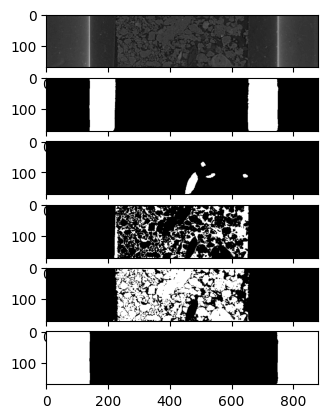

In [3]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print (np.unique(train_labels))

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(6,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img[0], cmap="gray")
axarr[1].imshow(label[0], cmap="gray");
axarr[2].imshow(label[1], cmap="gray");
axarr[3].imshow(label[2], cmap="gray");
axarr[4].imshow(label[3], cmap="gray");
axarr[5].imshow(label[4], cmap="gray");

plt.show();


In [ ]:
import torchvision
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch.utils.data import DataLoader, random_split
import torch
# from torch._six import container_abcs, string_classes, int_classes
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import psutil
import gc
import random
 
dir_checkpoint = models_directory
 
 
model_group=model_group
num_models=num_models
os.mkdir(dir_checkpoint+model_group)
seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
for i in range(num_models):
  #!!!!!!! Here we pull in a pretrained FCN on torch and we replace the output layer since we have six classes rather than 21!!!!!!!!
  num_classes=num_materials
  model=torchvision.models.segmentation.fcn_resnet101(progress=True)
  model.classifier=FCNHead(2048, num_classes)
  
  def trainval_split(dataset, val_fraction=0.5):
 
    validation_size = int(len(dataset) * val_fraction)
    train_size = len(dataset) - validation_size
    train, val = torch.utils.data.random_split(dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(i))
 
    return train, val
 
 
 
  dataset= BasicDataset(training_image_directory, training_mask_directory, scale=scale, transform=True)
  dataset_train, dataset_val=trainval_split(dataset, val_fraction=validation_fraction)

  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)#, collate_fn=pad_collate)
  val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)#, collate_fn=pad_collate)
 
 
  #%%
 
  # this is the train code 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  #!!!!!!!!!!!!!!!!!!!!!!!!!!!! Input epochs here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  num_epochs=num_epochs
  # read up on optimizers but Adam should work for now, if you get good results with Adam then you can try SGD (it's harder to tune but usually converges better)
  optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
  #optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
  #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
 
  #just initializing a value called best_loss
  best_loss=999
 
  # choose a loss function

  criterion = nn.BCEWithLogitsLoss()

  #this is the train loop
  for epoch in range(num_epochs):
      print(psutil.virtual_memory().percent)
      print('Epoch: ', str(epoch))
    #add back if doing fractional training
      train_loader.dataset.dataset.transform=True
      model.train()
      for images, masks in train_loader:
 
          images = images.to(device=device, dtype=torch.float32)
          masks = masks.to(device=device, dtype=torch.float32)
 
          #forward pass
          preds=model(images)['out'].cuda()
        
          #compute loss
          loss=criterion(preds, masks)
        
          #reset the optimizer gradients to 0
          optimizer.zero_grad()
 
          #backward pass (compute gradients)
          loss.backward()
 
          #use the computed gradients to update model weights
          optimizer.step()
 
          print('Train loss: '+str(loss.to('cpu').detach()))
      # model.eval()
      #add back if doing fractional training
      val_loader.dataset.dataset.transform=False
      current_loss=0
      
      #test on val set and save the best checkpoint
      model.eval()
      with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device=device, dtype=torch.float32)
            masks = masks.to(device=device, dtype=torch.float32)
            preds=model(images)['out'].cuda()
            # print(preds)
            # print(masks)
            loss=criterion(preds, masks)
            #print('hi')
            current_loss+=loss.to('cpu').detach()
            del images, masks, preds, loss
  #!!!!!!!!!!!!!!!!!!!!!!!!!!!Re-name model here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!        
      if best_loss>current_loss:
          best_loss=current_loss
          print('Best Model Saved!, loss: '+ str(best_loss))
          torch.save(model.state_dict(), dir_checkpoint+model_group + current_model_name+str(i+1)+".pth")
      else:
          print('Model is bad!, Current loss: '+ str(current_loss) + ' Best loss: '+str(best_loss))
      print('\n')
     

65.5
Epoch:  0
Train loss: tensor(0.6747)
Train loss: tensor(0.7203)
Train loss: tensor(0.6232)
Train loss: tensor(0.6489)
Train loss: tensor(0.3990)
Train loss: tensor(0.3658)
Train loss: tensor(0.2892)
Train loss: tensor(0.2721)
Train loss: tensor(0.7595)
Train loss: tensor(0.7759)
Train loss: tensor(0.4461)
Train loss: tensor(0.2811)
Train loss: tensor(0.2728)
Train loss: tensor(0.3805)
Train loss: tensor(0.2658)
Train loss: tensor(0.2205)
Train loss: tensor(0.2212)
Train loss: tensor(0.4101)
Train loss: tensor(0.2335)
Train loss: tensor(0.2224)
Train loss: tensor(0.2120)
Train loss: tensor(0.2115)
Train loss: tensor(0.5424)
Train loss: tensor(0.2023)
Best Model Saved!, loss: tensor(22.1933)


66.7
Epoch:  1
Train loss: tensor(0.4361)
Train loss: tensor(0.2849)
Train loss: tensor(0.2048)
Train loss: tensor(0.2091)
Train loss: tensor(0.2575)
Train loss: tensor(0.2289)
Train loss: tensor(0.4263)
Train loss: tensor(0.2833)
Train loss: tensor(0.2452)
Train loss: tensor(0.2606)
Train los

In [ ]:
#Code Box 6
import torch.nn as nn
import torchvision
import torch
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch.utils.data import DataLoader, random_split
#from statistics import mean
import numpy as np
import pandas as pd
# interim_list=[]
modeldata = pd.DataFrame(columns=["name", "precision", "recall", "accuracy", "f1"])

 
for s in range(num_models):

 
 
  model=torchvision.models.segmentation.fcn_resnet101()
  #!!!!!!!!!!!!!!!!!Specify Layer # here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  model.classifier=FCNHead(2048, num_materials)
  device = torch.device('cuda')
 
  outputs=[]
  model.to(device)
 
  #!!!!!!!!!!!!!!!!!!!!!Select Correct Model from the best models directory!!!!!!!!!!!!!!!!!!!!!!!!!1
 
  model.load_state_dict(torch.load(models_directory+model_group + current_model_name+str(s+1)+".pth"), strict=False)
 
 
  model.train()
 
  dataset_val = BasicDataset(test_images, test_masks, scale=scale, transform=False)
  val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)#, collate_fn=pad_collate)
 
  prop_list = []
  for mat in materials:
    prop_list.append([[],[],[],[]])
 
  for images, target in val_loader:
    images = images.to(device=device, dtype=torch.float32)
    target = target.to(device=device, dtype=torch.float32)
 
    with torch.no_grad():
      pred=model(images)['out'].cuda()
      pred=nn.Sigmoid()(pred)
    
    for i, mat in enumerate(materials):
      material_target=target[:,i,:,:]
      material_pred = pred[:, i, :, :]
      material_pred[material_pred >=mat.confidence_threshold] = 1
      material_pred[material_pred <=mat.confidence_threshold] = 0
      pred[:, i, :, :]=material_pred
 
      material_tp=torch.sum(material_target*material_pred, (1,2))
      material_fp=torch.sum((1-material_target)*material_pred, (1,2))
      material_fn=torch.sum(material_target*(1-material_pred), (1,2))
      material_tn=torch.sum((1-material_target)*(1-material_pred), (1,2))
 
     
 
      material_precision=torch.mean((material_tp+0.000000001)/(material_tp+material_fp+0.000000001))
      material_recall=torch.mean((material_tp+0.000000001)/(material_tp+material_fn+0.000000001))
      material_accuracy=torch.mean((material_tp+material_tn+0.000000001)/(material_tp+material_tn+material_fp+material_fn+0.000000001))
      material_f1=torch.mean(((material_tp+0.000000001))/(material_tp++0.000000001+0.5*(material_fp+material_fn)))
 
    
      prop_list[i][0].append(material_precision.cpu().detach().numpy())
      prop_list[i][1].append(material_recall.cpu().detach().numpy())
      prop_list[i][2].append(material_accuracy.cpu().detach().numpy())
      prop_list[i][3].append(material_f1.cpu().detach().numpy())
 
          
 
 
 
 
  model_name=current_model_name
  model_number=(str(s+1))
  print(model_name)
 
  #printing with pandas
  properties = {"name" : [mat.name for mat in materials],
                "precision" : [str(np.mean(prop_list[i][0])) for i in range(num_materials)],
                "recall" : [str(np.mean(prop_list[i][1])) for i in range(num_materials)],
                "accuracy" : [str(np.mean(prop_list[i][2])) for i in range(num_materials)],
                "f1" : [str(np.mean(prop_list[i][3])) for i in range(num_materials)]}
  df = pd.DataFrame(properties, columns = ["name", "precision", "recall", "accuracy", "f1"])
  df=pd.concat([df, pd.DataFrame(columns=["model number","model name"])])
  df[["model number","model name"]]=[model_number, model_name]
  # display(df)
  
  modeldata=modeldata.append([df], ignore_index=True)


display(modeldata)


In [ ]:
#Code Box 7
display(modeldata)
modeldata.to_csv(csv_directory)
     

In [ ]:
#Code Box 8
"""Input model number here"""
model_number='6'    

In [ ]:

#Code Box 9
import torch
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as T
import numpy as np
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
 
 
import time




 
model=torchvision.models.segmentation.fcn_resnet101(pretrained=False)

model.classifier=FCNHead(2048, num_materials)
 
device = torch.device('cuda')
 
outputs=[]
model.to(device)
 
#!!!!!!!!!!!!!!!!!!!!!Select Correct Model from the best models directory!!!!!!!!!!!!!!!!!!!!!!!!!1
model.load_state_dict(torch.load(models_directory+model_group + current_model_name+model_number+'.pth'), strict=False)
 
 
 
 
model.train()

In [ ]:
import os
import pandas as pd
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import argparse
import torch
import torchvision
from PIL import Image
import torch.nn as nn

from glob import glob
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from scipy.ndimage import morphology
sys.path.append(os.path.join(sys.path[0]))  # To find local version of the library

from torchvision.models.detection.rpn import AnchorGenerator
import torch
from skimage.color import rgb2gray, label2rgb



from skimage import io,exposure, feature, filters, io, measure, morphology, restoration, segmentation, transform, util, data, color
from skimage.measure import label, regionprops
from skimage.transform import rescale, resize, downscale_local_mean
import os
import numpy as np


#!!!!!!!!!!!!!!!!!!!!!Put the name of the folder with the images you want to analyze here!!!!!!!!!!!!!!!!!!!!!!!
dir_name = inference_directory

filenames = os.listdir(dir_name)


whole_leaf_tables=[]
file_name=[]
color=[]
value_counts=[]
sort_idx = np.argsort([(int(filename.split(proceeding)[1].split(following)[0])) for filename in filenames])
# sort_idx = np.argsort([(int(filename.split('.')[0])) for filename in filenames])
for i in sort_idx:
    #makes new directory called "(directory name here) + name in red" that your new images go into
    new_dir_name = output_directory
    if not os.path.exists(new_dir_name):
      os.makedirs(new_dir_name)
    
    for mat in materials:
      new_dir_name_mat= new_dir_name + mat.name
      if not os.path.exists(new_dir_name_mat):
        os.makedirs(new_dir_name_mat)
    filename = filenames[i]
    
    image = Image.open(dir_name +'/'+ filenames[i])
    image1 = (image)
    image1 = np.array(image1, dtype='ubyte')
    zeros=np.zeros_like(image1)
    
    w, h = image.size
    print(image.size)
    #!!!!!!!!!!!!!!!!!!!!Make sure scale matches!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    scale=scale
    newW, newH = int(scale * w), int(scale * h)
    image=image.resize((newW, newH))
    image_resize=image
    image=np.array(image)
    zeros2=np.zeros_like(image)

    new_im=np.zeros((3, newH, newW))
    
    new_im[0,:,:]=image
    new_im[1,:,:]=image
    new_im[2,:,:]=image
    image=new_im
    
    
    

    image=torch.from_numpy(image)

#!!!!!!!!!!!!!!!!!!!!!!!!!!Make sure normalization goes match above!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    image=T.Normalize(mean=mean, std=std)(image)
 
    image.unsqueeze_(0)
    image = image.to(device=device, dtype=torch.float32)


    tic=time.time()
    with torch.no_grad():
      mask=model(image)['out']
      mask=nn.Sigmoid()(mask)

    toc=time.time()
    print('time: '+str(toc-tic))
#!!!!!!!!!!!!!!!!!Make sure there are the same number of mask outputs as you trained on!!!!!!!!!!!!!!!!!!!!!

    image_rescaled=zeros2
    combined_image = np.array(image_rescaled, dtype='ubyte') 

    list_of_mat_tables = []
    for i, mat in enumerate(materials):
      mat_mask = mask.cpu().detach().numpy()[0,i,:,:]
      
      mat_mask[mat_mask >= mat.confidence_threshold] = mat.output_val
      mat_mask[mat_mask < mat.confidence_threshold] = 0

      mat_mask=np.array(mat_mask, dtype='ubyte')
      combined_image = np.add(combined_image, mat_mask[:,:])

      io.imsave(new_dir_name+'/' + mat.name + '/'+filename.split(following)[0]+'_' + mat.name + "_mask.png", mat_mask)
    
    io.imsave(new_dir_name+'/'+filename.split(following)[0]+'.png', combined_image, check_contrast=False)
      

In [ ]:
### SEGMENT ALL DATA 

